In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [21]:
import pandas as pd

class MnistDataset(torch.utils.data.Dataset):

    def __init__(self, file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data = pd.read_csv(file)
        print(data.shape)
        self.x = data[data.columns].values.reshape(-1, 28,28)[:, 3:25, 3:25] / 255
        #self.y = data[data.columns[0]].values
        del data
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,22,22).astype(np.float32)

In [22]:
mnist_dataset = MnistDataset("../../239_all/239/6.Intro_to_NN/data/test.csv")

(28000, 784)


In [23]:
mnist_dataset

In [24]:
dataloader = DataLoader(mnist_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# FACES

In [118]:
import cv2

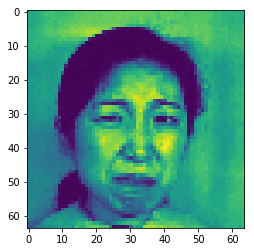

In [123]:
plt.imshow(cv2.resize(plt.imread("./data/jaffe/KA.DI3.44.tiff"), (64,64)))

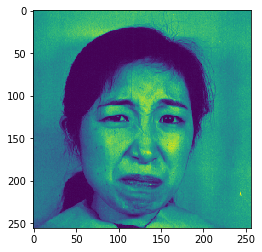

In [114]:
plt.imshow(plt.imread("./data/jaffe/KA.DI3.44.tiff"))

In [187]:
import pandas as pd
import os

class FacesDataset(torch.utils.data.Dataset):

    def __init__(self, path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        files = os.listdir(path)
        data = np.zeros((len(files), 64,64))
        for i, file in enumerate(files):
            pic = cv2.resize(plt.imread(path + file), (64,64))
            if len(pic.shape) > 2:
                pic = pic[:,:,0]
            data[i] = pic.reshape(64,64)
        
        #data = pd.read_csv(file)
        print(data.shape)
        self.x = data / 255
        del data
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx].reshape(1,64,64).astype(np.float32)

In [188]:
faces_dataset = FacesDataset("./data/jaffe/", transform=transforms.RandomAffine(1))

(213, 64, 64)


In [189]:
faces_dataset

In [190]:
dataloader = DataLoader(faces_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

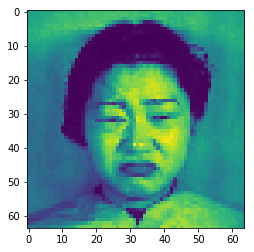

In [191]:
plt.imshow(faces_dataset.__getitem__(10)[0])

## VAE

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [10]:
import sys
sys.path.append("./models/encoder")

In [69]:
from models.models import *

In [70]:
vae =VAE((64,64), 100)

[64 64]
[32 32]
[16 16]


In [49]:
opt = optim.Adam(vae.parameters(), lr=0.001)

In [17]:
losses = []

In [18]:
mu,logvar = vae.enc(torch.randn(1,1,22,22))

In [19]:
vae.dec(mu).shape

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 1, 22, 22])

In [26]:
for epoch in range(10):
    for batch_idx, batch_x in enumerate(dataloader):
        opt.zero_grad()
        batch_x = batch_x#.view(-1, 784)
        out, mu, sigma = vae(batch_x)

    #     if i%100 == 0:
    #         loss = loss_function(out, batch_x, mu, sigma, v=1)
    #     else:
        loss = loss_function(out, batch_x, mu, sigma)
        loss.backward()
        opt.step()

        losses.append(loss.item() / len(batch_x))
        if batch_idx%20 == 0:
           #print(loss.item() / len(batch_x))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(batch_x), len(mnist_dataset),
                100. * batch_idx / len(dataloader),
                loss.item() / len(batch_x)))

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 0 [0/28000 (0%)]	Loss: 335.252930
Train Epoch: 0 [80/28000 (0%)]	Loss: 330.225800
Train Epoch: 0 [160/28000 (1%)]	Loss: 320.178162
Train Epoch: 0 [240/28000 (1%)]	Loss: 316.373657
Train Epoch: 0 [320/28000 (1%)]	Loss: 313.564636
Train Epoch: 0 [400/28000 (1%)]	Loss: 309.139496
Train Epoch: 0 [480/28000 (2%)]	Loss: 313.763519
Train Epoch: 0 [560/28000 (2%)]	Loss: 300.987122
Train Epoch: 0 [640/28000 (2%)]	Loss: 301.913940
Train Epoch: 0 [720/28000 (3%)]	Loss: 293.612305
Train Epoch: 0 [800/28000 (3%)]	Loss: 291.037079
Train Epoch: 0 [880/28000 (3%)]	Loss: 292.196228
Train Epoch: 0 [960/28000 (3%)]	Loss: 284.420563
Train Epoch: 0 [1040/28000 (4%)]	Loss: 285.628906
Train Epoch: 0 [1120/28000 (4%)]	Loss: 276.459534
Train Epoch: 0 [1200/28000 (4%)]	Loss: 282.922119
Train Epoch: 0 [1280/28000 (5%)]	Loss: 271.006042
Train Epoch: 0 [1360/28000 (5%)]	Loss: 263.914429
Train Epoch: 0 [1440/28000 (5%)]	Loss: 279.200439
Train Epoch: 0 [1520/28000 (5%)]	Loss: 265.811981
Train Epoch: 0 [

Train Epoch: 0 [12880/28000 (46%)]	Loss: 154.488983
Train Epoch: 0 [12960/28000 (46%)]	Loss: 140.786880
Train Epoch: 0 [13040/28000 (47%)]	Loss: 173.808182
Train Epoch: 0 [13120/28000 (47%)]	Loss: 171.900757
Train Epoch: 0 [13200/28000 (47%)]	Loss: 159.182037
Train Epoch: 0 [13280/28000 (47%)]	Loss: 196.393936
Train Epoch: 0 [13360/28000 (48%)]	Loss: 130.724274
Train Epoch: 0 [13440/28000 (48%)]	Loss: 134.007004
Train Epoch: 0 [13520/28000 (48%)]	Loss: 182.356155
Train Epoch: 0 [13600/28000 (49%)]	Loss: 176.266617
Train Epoch: 0 [13680/28000 (49%)]	Loss: 183.227737
Train Epoch: 0 [13760/28000 (49%)]	Loss: 130.205017
Train Epoch: 0 [13840/28000 (49%)]	Loss: 170.631042
Train Epoch: 0 [13920/28000 (50%)]	Loss: 200.341187
Train Epoch: 0 [14000/28000 (50%)]	Loss: 146.351959
Train Epoch: 0 [14080/28000 (50%)]	Loss: 153.944366
Train Epoch: 0 [14160/28000 (51%)]	Loss: 160.979568
Train Epoch: 0 [14240/28000 (51%)]	Loss: 139.486603
Train Epoch: 0 [14320/28000 (51%)]	Loss: 142.616104
Train Epoch:

Train Epoch: 0 [25520/28000 (91%)]	Loss: 132.059738
Train Epoch: 0 [25600/28000 (91%)]	Loss: 160.842834
Train Epoch: 0 [25680/28000 (92%)]	Loss: 158.303680
Train Epoch: 0 [25760/28000 (92%)]	Loss: 136.417618
Train Epoch: 0 [25840/28000 (92%)]	Loss: 150.773453
Train Epoch: 0 [25920/28000 (93%)]	Loss: 134.557404
Train Epoch: 0 [26000/28000 (93%)]	Loss: 121.734245
Train Epoch: 0 [26080/28000 (93%)]	Loss: 179.858536
Train Epoch: 0 [26160/28000 (93%)]	Loss: 155.786316
Train Epoch: 0 [26240/28000 (94%)]	Loss: 166.390106
Train Epoch: 0 [26320/28000 (94%)]	Loss: 133.967987
Train Epoch: 0 [26400/28000 (94%)]	Loss: 145.221939
Train Epoch: 0 [26480/28000 (95%)]	Loss: 160.336777
Train Epoch: 0 [26560/28000 (95%)]	Loss: 127.884468
Train Epoch: 0 [26640/28000 (95%)]	Loss: 99.664360
Train Epoch: 0 [26720/28000 (95%)]	Loss: 167.094406
Train Epoch: 0 [26800/28000 (96%)]	Loss: 183.807404
Train Epoch: 0 [26880/28000 (96%)]	Loss: 105.681717
Train Epoch: 0 [26960/28000 (96%)]	Loss: 124.109337
Train Epoch: 

Process Process-13:
Process Process-14:
Process Process-16:
Process Process-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/pytho

Train Epoch: 1 [4960/28000 (18%)]	Loss: 131.103745


  File "/home/anton/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/connection.py", lin

KeyboardInterrupt: 

/home/anton/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


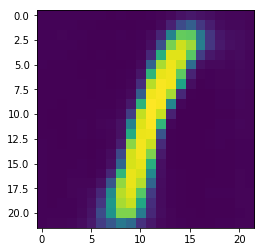

In [28]:
plt.imshow(vae(batch_x)[0][0].reshape(22,22).detach().numpy())

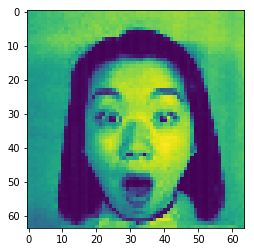

In [212]:
plt.imshow(batch_x[0].reshape(64,64).detach().numpy())

In [216]:
batch_x.shape

torch.Size([1, 1, 64, 64])

In [58]:
vae.dec(torch.randn(1, 10)).shape

torch.Size([1, 1, 28, 28])

In [226]:
vae.enc(batch_x)

(tensor([[  7.9019,   7.1082,   3.9043, -14.8400,  -0.8252,  -1.7435,   3.8550,
          -11.0614,  16.0926,  -2.0630]], grad_fn=<ThAddmmBackward>),
 tensor([[ -33.9994,  -48.2255, -134.0320, -394.1775, -170.5674, -283.9693,
          -308.1090, -147.7783,  -81.0785,  -21.4300]],
        grad_fn=<ThAddmmBackward>))

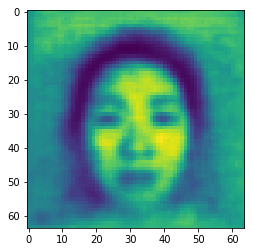

In [234]:
v = torch.from_numpy(np.array([[  1,   7.1082,   0, -14.8400,  -0.8252,  -1.7435,   3.8550,
          -11.0614,  16.0926,  -2.0630]])).view(1,10).float()
plt.imshow(vae.dec(v)[0][0].detach())

In [4]:
## read h5

import h5py
filename = './data/faces/donald.h5'


In [5]:
def read_h5(file):
    f = h5py.File(file, 'r')
    print("Keys: %s" % f.keys())
    
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    f.close()
    
    
    return np.stack(data)[:,:,:,0].reshape(-1,1,64,64)

In [6]:
data_trump = read_h5('./data/faces/donald.h5')
data_snowden = read_h5("./data/faces/snowden.h5")

Keys: KeysView(<HDF5 file "donald.h5" (mode r)>)
Keys: KeysView(<HDF5 file "snowden.h5" (mode r)>)


In [9]:
data_trump.shape

(85000, 1, 64, 64)

In [7]:
data_snowden.shape

(75765, 1, 64, 64)

In [36]:
nn.Conv2d(1, 1, (3, 3), stride=2, padding=1)(torch.rand(1,1,64,64)).shape

torch.Size([1, 1, 32, 32])

In [52]:
nn.ConvTranspose2d(1,1,(2,2), stride=2, padding = 0)(torch.rand(1,1,5,5)).shape

torch.Size([1, 1, 10, 10])

In [ ]:
nn.ConvTranspose2d(1,1,(2,2), stride=2, padding = 0)(torch.rand(1,1,5,5)).shape

In [56]:
nn.Conv2d(1,1,(3,3), padding=1)(torch.rand(1,1,10,10)).shape

torch.Size([1, 1, 10, 10])

In [59]:
DecoderBlock(1,1)(DecoderBlock(1,1)(torch.rand(1,1,5,5))).shape

torch.Size([1, 1, 20, 20])

In [61]:
EncoderBlock(1,1)(torch.rand(1,1,11,11)).shape

torch.Size([1, 1, 5, 5])

In [65]:
(1,2)[::-1]

[autoreload of models.models failed: Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/anton/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/anton/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/anton/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/anton/projs/VAE/mod

(2, 1)